## Continue with Analysis on Figured vs Not-Figured Split, Correct vs. Incorrect

### Setup

In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_model import ValueModel
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [3]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

### Some stats about trials 

In [4]:
# prep data for classification
pre_interval = 1300
post_interval = 1500

mode = "SpikeCounts"

figured_out = behavioral_utils.get_figured_out_trials(valid_beh)
not_figured_out = behavioral_utils.get_not_figured_out_trials(valid_beh)


In [9]:
print(f"Num Figured Out trials: {len(figured_out)}")
print(f"Num Not Figured Out trials: {len(not_figured_out)}")

correct_not_figured_out = not_figured_out[not_figured_out.Response == "Correct"]
print(f"Num correct trials in Not Figured Out: {len(correct_not_figured_out)}")

Num Figured Out trials: 592
Num Not Figured Out trials: 1157
Num correct trials in Not Figured Out: 447


### Re-evaluate Figured, Not Figured split when num trials is same for both
Subsample not figured out trials to match len of figured out

In [34]:
rng = np.random.default_rng(321)
sampled = rng.choice(not_figured_out.TrialNumber.unique(), len(figured_out), replace=False)
sampled_not_figured_out = not_figured_out[not_figured_out.TrialNumber.isin(sampled)]
print(len(sampled_not_figured_out))

592


Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

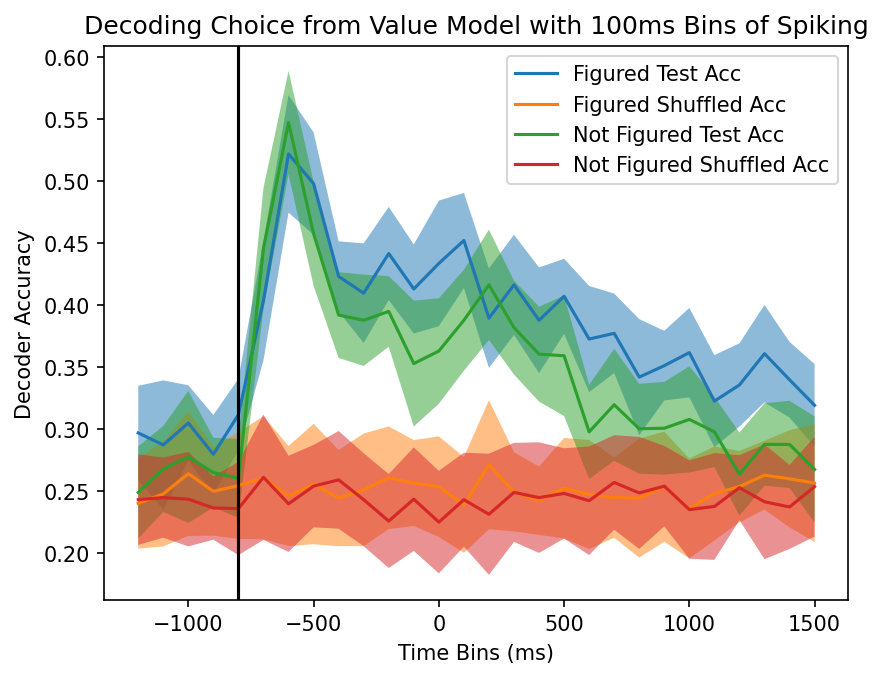

In [36]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

figured_inputs = inputs[inputs.TrialNumber.isin(figured_out.TrialNumber)]
figured_labels = labels[labels.TrialNumber.isin(figured_out.TrialNumber)]
figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(figured_out.TrialNumber)]
figured_splitter = RandomSplitter(figured_labels.TrialNumber.unique(), 20, 0.2)

not_figured_inputs = inputs[inputs.TrialNumber.isin(sampled_not_figured_out.TrialNumber)]
not_figured_labels = labels[labels.TrialNumber.isin(sampled_not_figured_out.TrialNumber)]
not_figured_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(sampled_not_figured_out.TrialNumber)]
not_figured_splitter = RandomSplitter(not_figured_labels.TrialNumber.unique(), 20, 0.2)

_, figured_test_accs, figured_shuffled_accs, figured_models, figured_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, figured_inputs, figured_labels, np.arange(0, 2.8, 0.1), figured_splitter, cards=figured_card_idxs
)

_, not_figured_test_accs, not_figured_shuffled_accs, not_figured_models, not_figured_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, not_figured_inputs, not_figured_labels, np.arange(0, 2.8, 0.1), not_figured_splitter, cards=not_figured_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Figured Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Figured Shuffled Acc",
    right_align=True
)

visualization_utils.visualize_accuracy_across_time_bins(
    not_figured_test_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Not Figured Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_figured_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Not Figured Shuffled Acc",
    right_align=True
)

ax.axvline(-800, color='k')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()

### For Not Figured, Split between Correct and Incorrect

In [38]:
correct_not_fig = not_figured_out[not_figured_out.Response == "Correct"]
incorrect_not_fig = not_figured_out[not_figured_out.Response == "Incorrect"]

rng = np.random.default_rng(321)
sampled = rng.choice(incorrect_not_fig.TrialNumber.unique(), len(correct_not_fig), replace=False)
sampled_incorrect_not_fig = incorrect_not_fig[incorrect_not_fig.TrialNumber.isin(sampled)]

print(len(correct_not_fig))
print(len(sampled_incorrect_not_fig))


447
447


Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

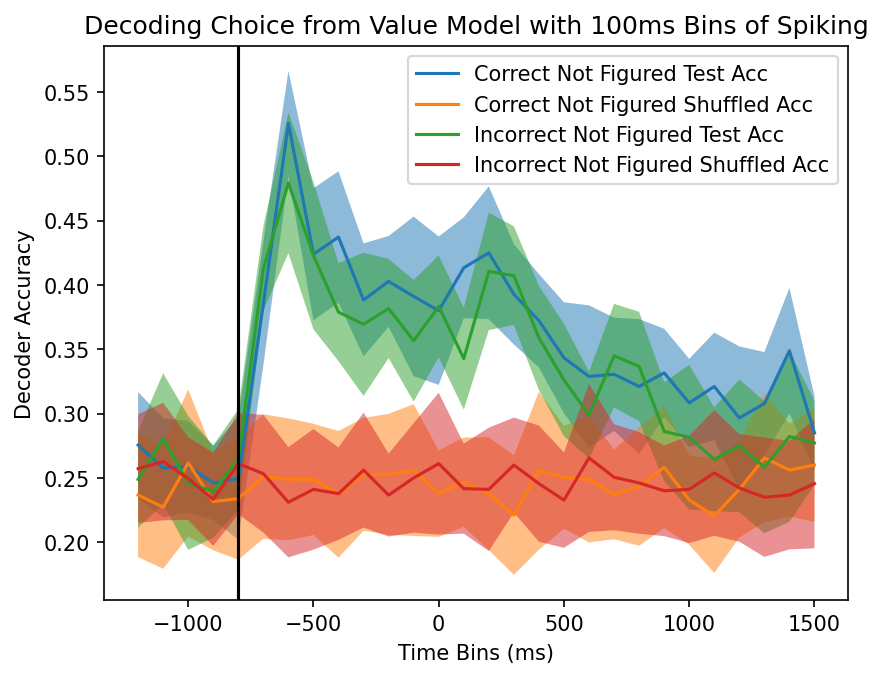

In [39]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

correct_not_fig_inputs = inputs[inputs.TrialNumber.isin(correct_not_fig.TrialNumber)]
correct_not_fig_labels = labels[labels.TrialNumber.isin(correct_not_fig.TrialNumber)]
correct_not_fig_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(correct_not_fig.TrialNumber)]
correct_not_fig_splitter = RandomSplitter(correct_not_fig_labels.TrialNumber.unique(), 20, 0.2)

sampled_incorrect_not_fig_inputs = inputs[inputs.TrialNumber.isin(sampled_incorrect_not_fig.TrialNumber)]
sampled_incorrect_not_fig_labels = labels[labels.TrialNumber.isin(sampled_incorrect_not_fig.TrialNumber)]
sampled_incorrect_not_fig_card_idxs = shuffled_card_idxs[shuffled_card_idxs.TrialNumber.isin(sampled_incorrect_not_fig.TrialNumber)]
sampled_incorrect_not_fig_splitter = RandomSplitter(sampled_incorrect_not_fig_labels.TrialNumber.unique(), 20, 0.2)

_, correct_accs, correct_shuffled_accs, correct_models, correct_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, correct_not_fig_inputs, correct_not_fig_labels, np.arange(0, 2.8, 0.1), correct_not_fig_splitter, cards=correct_not_fig_card_idxs
)

_, incorrect_accs, incorrect_shuffled_accs, incorrect_models, incorrect_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, sampled_incorrect_not_fig_inputs, sampled_incorrect_not_fig_labels, np.arange(0, 2.8, 0.1), sampled_incorrect_not_fig_splitter, cards=sampled_incorrect_not_fig_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    correct_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Correct Not Figured Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    correct_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Correct Not Figured Shuffled Acc",
    right_align=True
)

visualization_utils.visualize_accuracy_across_time_bins(
    incorrect_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Incorrect Not Figured Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    incorrect_shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Incorrect Not Figured Shuffled Acc",
    right_align=True
)

ax.axvline(-800, color='k')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()